# Model choosing and evaluation:

This notebook contains tunning of support vector classifier [1] and evaluation results of a model with tunned hyper-parameters.
However, several classifiers were tried: Knn-classifier with cosine similarity, and logistic regression with use of ovr. But all of these classiffiers did not succseed. 

One can agree that the reason of failures is the feature space. Encoding large text data leads to extremely sparce and high-dimensional feature space that is not good for classic ml classifiers. PCA was tried to reduce the dimension of the feature space, but to cover at least 95% of variance number of principal components is close to the initial dimensionality.

So to conclude, further investigations are required to increase the quality of results. More advance techniques, such as anensemble learning, stacking, word-embedding for text-to-feature converting and neural networks are required. 

[1] To be precise, Linear SVC was used, it is similar to SVC with linear kernel. However, it is more efficient to use with large datasets due to its implementation.

In [1]:
import pandas as pd
import os

TARGET_PATH = os.path.join("..", "data", "target.pkl")
TRAIN_ENC_PATH = os.path.join("..", "data", "train_encoded.npy")
TEST_ENC_PATH = os.path.join("..", "data", "test_encoded.npy")


In [2]:
import numpy as np

y = pd.read_pickle(TARGET_PATH)
X = np.load(TRAIN_ENC_PATH, allow_pickle=True)

In [3]:
# we can see that we have 1500 features
print(X.shape)
print(y.shape)

(91116, 1500)
(91116,)


In [4]:
from sklearn.model_selection import train_test_split
""" Splitting train dataset to train and test parts 
    to be able to evaluate our model.
    Also we keep the ratio of categories in the test part.
"""

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2, random_state=123)

In [5]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

""" Hyper parameter tunning with Greed Search.
    Regularization parametr is estimated.
"""

params = {"C": [1, 5, 10, 15]}

greed_search = GridSearchCV(
    param_grid=params,
    estimator=LinearSVC(random_state=123),
    cv=5,
    scoring="f1_weighted",
    n_jobs=3,
    verbose=3,
)
greed_search.fit(x_train, y_train)
print(greed_search.best_params_)
print(greed_search.best_score_)

# the result is Linear SVC with c=1.0

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/said/anaconda3/envs/env_jpt_notebooks/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV 3/5] END ...............................C=1;, score=0.803 total time= 2.0min
[CV 2/5] END ...............................C=1;, score=0.803 total time= 2.0min
[CV 1/5] END ...............................C=1;, score=0.805 total time= 2.1min
[CV 5/5] END ...............................C=1;, score=0.800 total time= 2.0min
[CV 4/5] END ...............................C=1;, score=0.807 total time= 2.1min
[CV 1/5] END ...............................C=5;, score=0.799 total time= 2.7min
[CV 2/5] END ...............................C=5;, score=0.795 total time= 2.6min
[CV 3/5] END ...............................C=5;, score=0.794 total time= 2.7min
[CV 4/5] END ...............................C=5;, score=0.797 total time= 2.6min
[CV 5/5] END ...............................C=5;, score=0.792 total time= 2.6min
[CV 1/5] END ..............................C=10;, score=0.792 total time= 3.1min
[CV 2/5] END ..............................C=10;, score=0.787 total time= 3.1min
[CV 3/5] END ...............

/home/said/anaconda3/envs/env_jpt_notebooks/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..............................C=15;, score=0.788 total time= 3.2min
[CV 2/5] END ..............................C=15;, score=0.784 total time= 3.3min
[CV 3/5] END ..............................C=15;, score=0.783 total time= 3.3min
[CV 4/5] END ..............................C=15;, score=0.788 total time= 3.0min


/home/said/anaconda3/envs/env_jpt_notebooks/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..............................C=15;, score=0.783 total time= 2.7min
{'C': 1}
0.8034910503750783


In [5]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=1.0, random_state=123)
svc.fit(x_train, y_train)

LinearSVC(random_state=123)

In [6]:
from sklearn.metrics import f1_score
# getting f1-weighted score

y_pred = svc.predict(x_test)
f1_score(y_test,y_pred, average='weighted')

0.8120005633299404

In [7]:
# get predicton for test dataset

test = np.load(TEST_ENC_PATH, allow_pickle=True)
y_results = svc.predict(test)


In [8]:
TEST_EXT_PATH = os.path.join("..", "data", "test_extended.pkl")

product_id = np.array(pd.read_pickle(TEST_EXT_PATH)["product_id"])

result = pd.DataFrame(
    {
        "product_id": product_id,
        "predicted_category_id": y_results,
    }
)
result

,product_id,predicted_category_id
0,1997646,2755
1,927375,14922
2,1921513,2803
3,1668662,12044
4,1467778,11581
...,...,...
16855,1914264,11645
16856,1310569,12357
16857,978095,13651
16858,797547,2740


In [9]:
RESULT_PATH = os.path.join('..','result.parquet')
pd.DataFrame.to_parquet(result, RESULT_PATH)

## Get confidence interval for f1_weighted statistic:

In [10]:
from sklearn.utils import resample
""" Apply bootstrapping to simulate the distribution of f1_weighted"""

n_resamples = 1000
f1_scores = []

for i in range(n_resamples):
    test, actual = resample(x_test, y_test, stratify=y_test, replace=True)
    pred = svc.predict(test)
    f1_scores.append(f1_score(actual, pred, average='weighted'))
f1_scores




[0.8140703661434605,
 0.8119780226132173,
 0.8114968099936071,
 0.8106872169197372,
 0.8109119286564962,
 0.8121224450274257,
 0.8086702183534009,
 0.8079159398005651,
 0.8089228527740515,
 0.8148371516363826,
 0.8093051160424399,
 0.8123384096903608,
 0.8106927860087613,
 0.8131847193121398,
 0.8091160524764345,
 0.810590147174833,
 0.8082311419603222,
 0.8087459813358888,
 0.8123997733860646,
 0.811169882707729,
 0.8123173735188809,
 0.810785983150871,
 0.8086710086856809,
 0.8113814742269905,
 0.8094798175149532,
 0.8109064115828561,
 0.8144680184299059,
 0.8179287456619596,
 0.8111346389370148,
 0.8147098061915495,
 0.808942389437634,
 0.8079495949658548,
 0.8088342182032755,
 0.8133510748477459,
 0.8105363987556566,
 0.8124411574876189,
 0.8110171020926419,
 0.8094921674260142,
 0.8073545677451505,
 0.8077815691472114,
 0.8071537134303995,
 0.8098428718291207,
 0.811121509875093,
 0.8158861658181773,
 0.8127424717440298,
 0.8106978174178723,
 0.811628475988571,
 0.8131312856204427

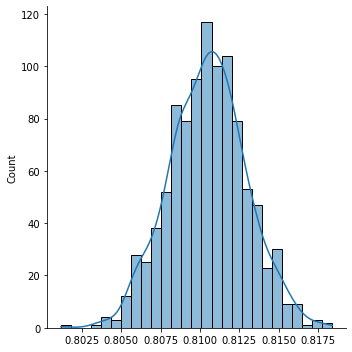

In [12]:
import seaborn as sns
sns.displot(f1_scores, kde=True)


**Mean for f1_weighted:**

In [13]:
np.mean(f1_scores)

0.8104893063881606

**95-confidence interval for f1_weighted**

In [14]:
left_bound = np.quantile(f1_scores, 0.025)
right_bound = np.quantile(f1_scores, 0.975)
print( f"95-confidence interval for f1_weighted is [{left_bound},{right_bound}]")

95-confidence interval for f1_weighted is [0.8057792039111553,0.8151792037648334]


## Save the model

In [17]:
import pickle

MODEL_PATH = os.path.join(".", "svc.sav")

with open(MODEL_PATH, "wb") as file:
    pickle.dump(svc, file)